In [103]:
import numpy as np
import pandas as pd
import sklearn
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler
)
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
import matplotlib.pyplot as plt

## Display Settings

In [56]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

## Read the Data

In [57]:
path = r"S:\Linear Regression Project\Flight Price Prediction\Data\train.csv"
train = pd.read_csv(path)

In [58]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Delhi,Cochin,19:10:00,04:25:00,1995,2.0,In-flight meal not included,8834
1,Jet Airways,2019-03-06,Banglore,New Delhi,08:00:00,07:40:00,1420,1.0,No Info,14815
2,Jet Airways,2019-05-21,Kolkata,Banglore,17:00:00,14:25:00,1285,1.0,No Info,11467
3,Jet Airways,2019-05-21,Kolkata,Banglore,20:00:00,09:20:00,800,1.0,No Info,14781
4,Multiple Carriers,2019-06-27,Delhi,Cochin,09:00:00,21:00:00,720,1.0,No Info,7408


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [60]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## Transformation Operations

### airline

In [61]:
train.airline

0            Jet Airways
1            Jet Airways
2            Jet Airways
3            Jet Airways
4      Multiple Carriers
             ...        
635              Vistara
636             Air Asia
637            Air India
638          Jet Airways
639             Air Asia
Name: airline, Length: 640, dtype: object

In [62]:
air_transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy='most_frequent')),
    ("groups", RareLabelEncoder(tol=0.1, replace_with="other",n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,0.0,0.0,1.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### date_of_journey

In [63]:
X_train.date_of_journey

0      2019-03-21
1      2019-03-06
2      2019-05-21
3      2019-05-21
4      2019-06-27
          ...    
635    2019-03-24
636    2019-06-15
637    2019-06-24
638    2019-06-03
639    2019-03-27
Name: date_of_journey, Length: 640, dtype: object

In [64]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]
doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.058824,0.333333,0.042373
2,0.666667,0.705882,0.166667,0.686441
3,0.666667,0.705882,0.166667,0.686441
4,1.000000,1.000000,0.500000,1.000000
...,...,...,...,...
635,0.000000,0.176471,1.000000,0.194915
636,1.000000,0.882353,0.833333,0.898305
637,1.000000,1.000000,0.000000,0.974576
638,1.000000,0.823529,0.000000,0.796610


### souorce and destination

In [65]:
X_train.source

0         Delhi
1      Banglore
2       Kolkata
3       Kolkata
4         Delhi
         ...   
635    Banglore
636       Delhi
637       Delhi
638       Delhi
639       Delhi
Name: source, Length: 640, dtype: object

In [66]:
X_train.destination

0         Cochin
1      New Delhi
2       Banglore
3       Banglore
4         Cochin
         ...    
635    New Delhi
636       Cochin
637       Cochin
638       Cochin
639       Cochin
Name: destination, Length: 640, dtype: object

In [67]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Banglore,New Delhi
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
635,Banglore,New Delhi
636,Delhi,Cochin
637,Delhi,Cochin
638,Delhi,Cochin


In [68]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.024601,1.025158
1,-1.144031,-1.084716
2,-0.168106,-0.169107
3,-0.168106,-0.169107
4,1.024601,1.025158
...,...,...
635,-1.144031,-1.084716
636,1.024601,1.025158
637,1.024601,1.025158
638,1.024601,1.025158


In [69]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [70]:
def is_north(X):
    columns = X.columns.to_list()
    nort_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X.assign(**{
            f"{col}_is_north": X.loc[:, col].isin(nort_cities).astype(int)
            for col in columns
        }) .drop(columns = columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [71]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.024601,1.025158,1,0
1,-1.144031,-1.084716,0,1
2,-0.168106,-0.169107,1,0
3,-0.168106,-0.169107,1,0
4,1.024601,1.025158,1,0
...,...,...,...,...
635,-1.144031,-1.084716,0,1
636,1.024601,1.025158,1,0
637,1.024601,1.025158,1,0
638,1.024601,1.025158,1,0


### dep_time and arrival_time

In [72]:
X_train.dep_time

0      19:10:00
1      08:00:00
2      17:00:00
3      20:00:00
4      09:00:00
         ...   
635    07:00:00
636    07:55:00
637    10:00:00
638    11:30:00
639    16:45:00
Name: dep_time, Length: 640, dtype: object

In [73]:
X_train.arrival_time

0      04:25:00
1      07:40:00
2      14:25:00
3      09:20:00
4      21:00:00
         ...   
635    09:40:00
636    22:25:00
637    19:15:00
638    19:00:00
639    07:10:00
Name: arrival_time, Length: 640, dtype: object

In [74]:
time_subset = X_train.loc[:,["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,19:10:00,04:25:00
1,08:00:00,07:40:00
2,17:00:00,14:25:00
3,20:00:00,09:20:00
4,09:00:00,21:00:00
...,...,...
635,07:00:00,09:40:00
636,07:55:00,22:25:00
637,10:00:00,19:15:00
638,11:30:00,19:00:00


In [75]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler()),
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.826087,0.181818,0.173913,0.454545
1,0.347826,0.000000,0.304348,0.727273
2,0.739130,0.000000,0.608696,0.454545
3,0.869565,0.000000,0.391304,0.363636
4,0.391304,0.000000,0.913043,0.000000
...,...,...,...,...
635,0.304348,0.000000,0.391304,0.727273
636,0.304348,1.000000,0.956522,0.454545
637,0.434783,0.000000,0.826087,0.272727
638,0.478261,0.545455,0.826087,0.000000


In [76]:
def part_of_day(X, morninig=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return(
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morninig,noon, inclusive="left"),
                 X_temp.loc[:,col].between(noon,eve, inclusive="left"),
                 X_temp.loc[:,col].between(eve,night, inclusive="left")],
                 ["morning","afternoon","evening"],
                 default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,morning
1,morning,morning
2,evening,afternoon
3,night,morning
4,morning,night
...,...,...
635,morning,morning
636,morning,night
637,morning,evening
638,morning,evening


In [77]:
time_pipe2 = Pipeline(steps=[
    ("part1", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.146789,0.883929
1,1.000000,0.883929
2,0.146789,0.000000
3,0.137615,0.883929
4,1.000000,1.000000
...,...,...
635,1.000000,0.883929
636,1.000000,1.000000
637,1.000000,0.580357
638,1.000000,0.580357


In [93]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.826087,0.181818,0.173913,0.454545,0.146789,0.883929
1,0.347826,0.000000,0.304348,0.727273,1.000000,0.883929
2,0.739130,0.000000,0.608696,0.454545,0.146789,0.000000
3,0.869565,0.000000,0.391304,0.363636,0.137615,0.883929
4,0.391304,0.000000,0.913043,0.000000,1.000000,1.000000
...,...,...,...,...,...,...
635,0.304348,0.000000,0.391304,0.727273,1.000000,0.883929
636,0.304348,1.000000,0.956522,0.454545,1.000000,1.000000
637,0.434783,0.000000,0.826087,0.272727,1.000000,0.580357
638,0.478261,0.545455,0.826087,0.000000,1.000000,0.580357


### duration

In [78]:
X_train.duration

0      1995
1      1420
2      1285
3       800
4       720
       ... 
635     160
636     870
637     555
638     450
639     865
Name: duration, Length: 640, dtype: int64

In [79]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
)

array([[175. ],
       [535. ],
       [932.5]])

In [80]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [81]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,0.904837,0.904837
636,0.000000e+00,0.0,1.000000,1.000000
637,0.000000e+00,0.0,1.000000,1.000000
638,7.901742e-142,0.0,1.000000,1.000000


In [82]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [83]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [84]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.324338,-0.113005,-0.097296,2.0,1,2.693377
1,-0.324338,-0.113005,-0.097296,2.0,1,1.540688
2,-0.324338,-0.113005,-0.097296,2.0,1,1.270057
3,-0.324338,-0.113005,-0.097296,2.0,0,0.297788
4,-0.324338,-0.113005,-0.097296,2.0,0,0.137414
...,...,...,...,...,...,...
635,-0.324338,-0.113005,-0.097296,0.0,0,-0.985205
636,-0.324338,-0.113005,-0.097296,2.0,0,0.438116
637,-0.324338,-0.113005,-0.097296,2.0,0,-0.193357
638,-0.324338,-0.113005,-0.097296,2.0,0,-0.403848


### total_stops

In [85]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,1.0,0
638,1.0,0


### additional_info

In [91]:
train.additional_info

0      In-flight meal not included
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638    In-flight meal not included
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [86]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,1.0,0.0,0.0


In [87]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [88]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [89]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,1.0,0.0,0.0,1


## Column Transformer

In [94]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.024601,1.025158,1,0,0.826087,0.181818,0.173913,0.454545,0.146789,0.883929,-0.324338,-0.113005,-0.097296,2.0,1,2.693377,2.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-1.144031,-1.084716,0,1,0.347826,0.000000,0.304348,0.727273,1.000000,0.883929,-0.324338,-0.113005,-0.097296,2.0,1,1.540688,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.168106,-0.169107,1,0,0.739130,0.000000,0.608696,0.454545,0.146789,0.000000,-0.324338,-0.113005,-0.097296,2.0,1,1.270057,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.168106,-0.169107,1,0,0.869565,0.000000,0.391304,0.363636,0.137615,0.883929,-0.324338,-0.113005,-0.097296,2.0,0,0.297788,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.500000,1.000000,1.024601,1.025158,1,0,0.391304,0.000000,0.913043,0.000000,1.000000,1.000000,-0.324338,-0.113005,-0.097296,2.0,0,0.137414,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.000000,0.176471,1.000000,0.194915,-1.144031,-1.084716,0,1,0.304348,0.000000,0.391304,0.727273,1.000000,0.883929,-0.324338,-0.113005,-0.097296,0.0,0,-0.985205,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,0.0,0.0,1.0,1.000000,0.882353,0.833333,0.898305,1.024601,1.025158,1,0,0.304348,1.000000,0.956522,0.454545,1.000000,1.000000,-0.324338,-0.113005,-0.097296,2.0,0,0.438116,1.0,0,0.0,1.0,0.0,0
637,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,1.024601,1.025158,1,0,0.434783,0.000000,0.826087,0.272727,1.000000,0.580357,-0.324338,-0.113005,-0.097296,2.0,0,-0.193357,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.024601,1.025158,1,0,0.478261,0.545455,0.826087,0.000000,1.000000,0.580357,-0.324338,-0.113005,-0.097296,2.0,0,-0.403848,1.0,0,1.0,0.0,0.0,1


## Feature Selection

In [97]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## Putting all Together

In [98]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,1.024601,1.025158,2.0,1,2.693377,2.0,0
1,0.0,1.0,0.0,0.058824,0.042373,-1.144031,-1.084716,2.0,1,1.540688,1.0,0
2,0.0,1.0,0.0,0.705882,0.686441,-0.168106,-0.169107,2.0,1,1.270057,1.0,0
3,0.0,1.0,0.0,0.705882,0.686441,-0.168106,-0.169107,2.0,0,0.297788,1.0,0
4,0.0,0.0,0.0,1.000000,1.000000,1.024601,1.025158,2.0,0,0.137414,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.176471,0.194915,-1.144031,-1.084716,0.0,0,-0.985205,0.0,1
636,0.0,0.0,1.0,0.882353,0.898305,1.024601,1.025158,2.0,0,0.438116,1.0,0
637,0.0,0.0,0.0,1.000000,0.974576,1.024601,1.025158,2.0,0,-0.193357,1.0,0
638,0.0,1.0,0.0,0.823529,0.796610,1.024601,1.025158,2.0,0,-0.403848,1.0,0


In [99]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0012179742991600406,
 'air__airline_Indigo': 0.15744135814090945,
 'air__airline_Jet Airways': 0.1870430571179318,
 'air__airline_Multiple Carriers': 0.00595319575885193,
 'air__airline_other': 0.11425852546551007,
 'doj__date_of_journey_month': 0.07014136800580088,
 'doj__date_of_journey_week': 0.13228309908794725,
 'doj__date_of_journey_day_of_week': -0.017825671239358482,
 'doj__date_of_journey_day_of_year': 0.11344672694780993,
 'location__source': 0.14614176466671217,
 'location__destination': 0.13995980562823493,
 'location__source_is_north': 0.04322629253937349,
 'location__destination_is_north': 0.04322629253937349,
 'time__dep_time_hour': 0.01044381272829246,
 'time__dep_time_minute': 0.01880631817250929,
 'time__arrival_time_hour': 0.07842072036683863,
 'time__arrival_time_minute': 0.04277478022564907,
 'time__dep_time_part_of_day': -0.01031830012304602,
 'time__arrival_time_part_of_day': 0.006294065292232494,
 'dur__duration_rbf_25': 0.0952500823

In [100]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.017825671239358482,
 'time__dep_time_part_of_day': -0.01031830012304602,
 'dur__duration_rbf_50': -0.009675702456041657,
 'info__additional_info_No Info': -0.007796328845964669,
 'info__additional_info': -0.007796328845964669,
 'info__additional_info_In-flight meal not included': -0.0031042275001302486,
 'dur__duration_rbf_75': -0.002251632170843121,
 'air__airline_Air India': 0.0012179742991600406,
 'air__airline_Multiple Carriers': 0.00595319575885193,
 'time__arrival_time_part_of_day': 0.006294065292232494,
 'time__dep_time_hour': 0.01044381272829246,
 'time__dep_time_minute': 0.01880631817250929,
 'time__arrival_time_minute': 0.04277478022564907,
 'location__source_is_north': 0.04322629253937349,
 'location__destination_is_north': 0.04322629253937349,
 'info__additional_info_Other': 0.04449208196118944,
 'doj__date_of_journey_month': 0.07014136800580088,
 'time__arrival_time_hour': 0.07842072036683863,
 'dur__duration_rbf_25': 0.0952500823474

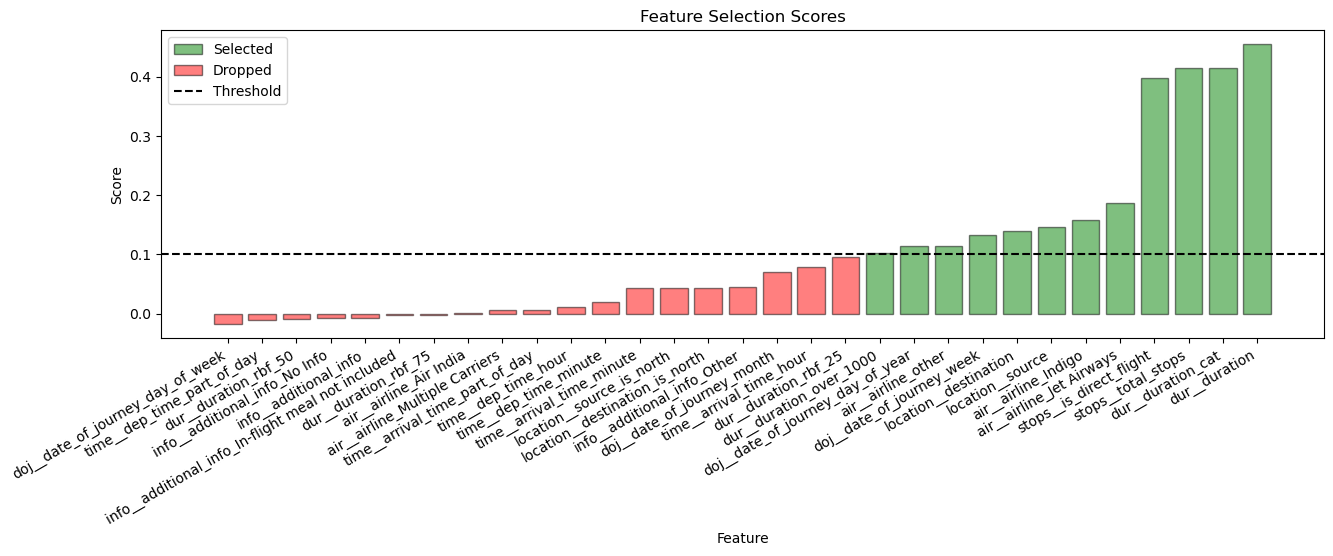

In [104]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()